In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In this Kaggle competition we need to the predict the value of transaction each customers will carry out given a set of features. 

In [4]:
#Load the training set
train = pd.read_csv('train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [4]:
#Check for any NaN in the dataframe
train.isnull().values.any()

False

In [5]:
train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


The features are anonymized

In [5]:
test = pd.read_csv('test.csv')

Let us look more into the training dataset and look at the mean, S.D and variance of the features.

In [7]:
features_train = train.describe().T

In [8]:
np.sum(features_train['std']<=0)

256

We see that we have at least 256 features that have zero standard deviation which means that they are just a constant term and can be removed from the dataset. But we must also confirm that we have the same number from the test set too

In [21]:
features_test = test.describe().T

In [27]:
np.sum(features_test['std']<=0.0)

0

The std for all the features seems to be non-zero for the test set. We will thus not remove any data as of now

### Plotting the target distribution

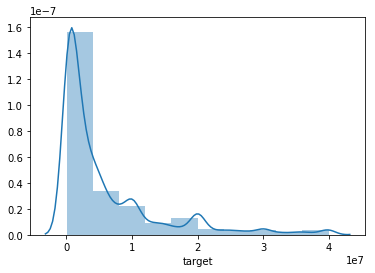

In [9]:
sns.distplot(train['target'], bins = 10)

The target is heavily skewed towards zero. Let us take a logarithm of the target and then take a histogram.

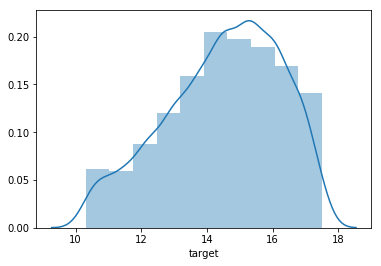

In [10]:
sns.distplot(np.log1p(train['target']), bins = 10)

Because of the presence of several zeroes in the target, it was tranformed using $log\left(1+x\right)$ to avoid null values. It will also be much easier to deal with this transformed target for the purposes of any sort of predictive analysis and modelling. This can be easily reversed using the function $e^x-1$.

In [7]:
X = train.iloc[:, 2:].values
y = np.log1p(train.iloc[:, 1].values)# to make it easier to carry out modeling 

In [8]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Random Forest Trial

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

In [18]:
model_rf = RandomForestRegressor(n_estimators= 600, criterion= 'mse', max_depth= 30,
                              min_samples_split=5, min_samples_leaf= 2,max_features='auto',
                              bootstrap= 'True')

In [19]:
print(model_rf.get_params())

{'bootstrap': 'True', 'criterion': 'mse', 'max_depth': 30, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 600, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [20]:
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap='True', criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [21]:
y_pred = model_rf.predict(X_test)

In [22]:
print('The Root Mean Log Square Error is: {0:0.6f}'.format(mean_squared_log_error(y_test, y_pred)))

The Root Mean Log Square Error is: 0.008620


### XGBoost

In [10]:
import xgboost as xgb
from xgboost import XGBRegressor

In [11]:
xgb_model = XGBRegressor(max_depth = 10, 
                         learning_rate= 0.003, 
                         booster = 'gbtree',
                         n_estimators= 3000, 
                         n_jobs = -1, 
                         subsample= 0.7, 
                         colsample_bytree= 0.5)

In [12]:
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse', early_stopping_rounds=50, verbose=True)

[0]	validation_0-rmse:14.0711	validation_1-rmse:14.0171
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:14.0297	validation_1-rmse:13.9756
[2]	validation_0-rmse:13.9883	validation_1-rmse:13.9343
[3]	validation_0-rmse:13.947	validation_1-rmse:13.893
[4]	validation_0-rmse:13.9058	validation_1-rmse:13.8518
[5]	validation_0-rmse:13.8648	validation_1-rmse:13.8108
[6]	validation_0-rmse:13.8239	validation_1-rmse:13.7699
[7]	validation_0-rmse:13.7832	validation_1-rmse:13.7292
[8]	validation_0-rmse:13.7425	validation_1-rmse:13.6884
[9]	validation_0-rmse:13.702	validation_1-rmse:13.648
[10]	validation_0-rmse:13.6616	validation_1-rmse:13.6076
[11]	validation_0-rmse:13.6213	validation_1-rmse:13.5673
[12]	validation_0-rmse:13.5811	validation_1-rmse:13.5271
[13]	validation_0-rmse:13.541	validation_1-rmse:13.487
[14]	validation_0-rmse:13.5011	validation_1-rmse:13.4472
[1

[142]	validation_0-rmse:9.27575	validation_1-rmse:9.2235
[143]	validation_0-rmse:9.24896	validation_1-rmse:9.19685
[144]	validation_0-rmse:9.22203	validation_1-rmse:9.16998
[145]	validation_0-rmse:9.19535	validation_1-rmse:9.14339
[146]	validation_0-rmse:9.16868	validation_1-rmse:9.11671
[147]	validation_0-rmse:9.1421	validation_1-rmse:9.09011
[148]	validation_0-rmse:9.11565	validation_1-rmse:9.06376
[149]	validation_0-rmse:9.08927	validation_1-rmse:9.03732
[150]	validation_0-rmse:9.06284	validation_1-rmse:9.01105
[151]	validation_0-rmse:9.03657	validation_1-rmse:8.98491
[152]	validation_0-rmse:9.01033	validation_1-rmse:8.95863
[153]	validation_0-rmse:8.98427	validation_1-rmse:8.93257
[154]	validation_0-rmse:8.95823	validation_1-rmse:8.9068
[155]	validation_0-rmse:8.93235	validation_1-rmse:8.88093
[156]	validation_0-rmse:8.9065	validation_1-rmse:8.85512
[157]	validation_0-rmse:8.88075	validation_1-rmse:8.82957
[158]	validation_0-rmse:8.85506	validation_1-rmse:8.80387
[159]	validation_0

[284]	validation_0-rmse:6.17289	validation_1-rmse:6.13776
[285]	validation_0-rmse:6.1554	validation_1-rmse:6.12044
[286]	validation_0-rmse:6.13811	validation_1-rmse:6.10327
[287]	validation_0-rmse:6.12081	validation_1-rmse:6.08624
[288]	validation_0-rmse:6.10365	validation_1-rmse:6.06937
[289]	validation_0-rmse:6.08651	validation_1-rmse:6.05245
[290]	validation_0-rmse:6.06938	validation_1-rmse:6.03562
[291]	validation_0-rmse:6.05225	validation_1-rmse:6.01863
[292]	validation_0-rmse:6.03517	validation_1-rmse:6.0018
[293]	validation_0-rmse:6.0183	validation_1-rmse:5.98498
[294]	validation_0-rmse:6.00142	validation_1-rmse:5.96834
[295]	validation_0-rmse:5.98451	validation_1-rmse:5.95147
[296]	validation_0-rmse:5.96772	validation_1-rmse:5.93507
[297]	validation_0-rmse:5.95096	validation_1-rmse:5.91848
[298]	validation_0-rmse:5.9343	validation_1-rmse:5.90198
[299]	validation_0-rmse:5.91763	validation_1-rmse:5.88539
[300]	validation_0-rmse:5.90102	validation_1-rmse:5.86883
[301]	validation_0

[426]	validation_0-rmse:4.17271	validation_1-rmse:4.17144
[427]	validation_0-rmse:4.16148	validation_1-rmse:4.16064
[428]	validation_0-rmse:4.15034	validation_1-rmse:4.14982
[429]	validation_0-rmse:4.13926	validation_1-rmse:4.1389
[430]	validation_0-rmse:4.12818	validation_1-rmse:4.12801
[431]	validation_0-rmse:4.11733	validation_1-rmse:4.11733
[432]	validation_0-rmse:4.10634	validation_1-rmse:4.10664
[433]	validation_0-rmse:4.09546	validation_1-rmse:4.09611
[434]	validation_0-rmse:4.08456	validation_1-rmse:4.08548
[435]	validation_0-rmse:4.07366	validation_1-rmse:4.07487
[436]	validation_0-rmse:4.06283	validation_1-rmse:4.06437
[437]	validation_0-rmse:4.05202	validation_1-rmse:4.05393
[438]	validation_0-rmse:4.04125	validation_1-rmse:4.04336
[439]	validation_0-rmse:4.03055	validation_1-rmse:4.03298
[440]	validation_0-rmse:4.0199	validation_1-rmse:4.02285
[441]	validation_0-rmse:4.0092	validation_1-rmse:4.01252
[442]	validation_0-rmse:3.99858	validation_1-rmse:4.00213
[443]	validation_

[568]	validation_0-rmse:2.89705	validation_1-rmse:2.9503
[569]	validation_0-rmse:2.89002	validation_1-rmse:2.94373
[570]	validation_0-rmse:2.88301	validation_1-rmse:2.93713
[571]	validation_0-rmse:2.87599	validation_1-rmse:2.93057
[572]	validation_0-rmse:2.86897	validation_1-rmse:2.92392
[573]	validation_0-rmse:2.86196	validation_1-rmse:2.91753
[574]	validation_0-rmse:2.85499	validation_1-rmse:2.91113
[575]	validation_0-rmse:2.84812	validation_1-rmse:2.90459
[576]	validation_0-rmse:2.84128	validation_1-rmse:2.89811
[577]	validation_0-rmse:2.8344	validation_1-rmse:2.89174
[578]	validation_0-rmse:2.82752	validation_1-rmse:2.88536
[579]	validation_0-rmse:2.82066	validation_1-rmse:2.8789
[580]	validation_0-rmse:2.81382	validation_1-rmse:2.87254
[581]	validation_0-rmse:2.807	validation_1-rmse:2.86619
[582]	validation_0-rmse:2.80023	validation_1-rmse:2.8598
[583]	validation_0-rmse:2.79337	validation_1-rmse:2.85343
[584]	validation_0-rmse:2.78672	validation_1-rmse:2.84728
[585]	validation_0-r

[710]	validation_0-rmse:2.10035	validation_1-rmse:2.22642
[711]	validation_0-rmse:2.09605	validation_1-rmse:2.22272
[712]	validation_0-rmse:2.09169	validation_1-rmse:2.2189
[713]	validation_0-rmse:2.08732	validation_1-rmse:2.21512
[714]	validation_0-rmse:2.08304	validation_1-rmse:2.21153
[715]	validation_0-rmse:2.07883	validation_1-rmse:2.20778
[716]	validation_0-rmse:2.07448	validation_1-rmse:2.20396
[717]	validation_0-rmse:2.07024	validation_1-rmse:2.2003
[718]	validation_0-rmse:2.06597	validation_1-rmse:2.19654
[719]	validation_0-rmse:2.06169	validation_1-rmse:2.19293
[720]	validation_0-rmse:2.05754	validation_1-rmse:2.18941
[721]	validation_0-rmse:2.05335	validation_1-rmse:2.1858
[722]	validation_0-rmse:2.04918	validation_1-rmse:2.18209
[723]	validation_0-rmse:2.04499	validation_1-rmse:2.17854
[724]	validation_0-rmse:2.04091	validation_1-rmse:2.17501
[725]	validation_0-rmse:2.03675	validation_1-rmse:2.17136
[726]	validation_0-rmse:2.03277	validation_1-rmse:2.16788
[727]	validation_

[852]	validation_0-rmse:1.61964	validation_1-rmse:1.82808
[853]	validation_0-rmse:1.61708	validation_1-rmse:1.82607
[854]	validation_0-rmse:1.61457	validation_1-rmse:1.82416
[855]	validation_0-rmse:1.61203	validation_1-rmse:1.82215
[856]	validation_0-rmse:1.60943	validation_1-rmse:1.82015
[857]	validation_0-rmse:1.60679	validation_1-rmse:1.81803
[858]	validation_0-rmse:1.60425	validation_1-rmse:1.81604
[859]	validation_0-rmse:1.60179	validation_1-rmse:1.81408
[860]	validation_0-rmse:1.59936	validation_1-rmse:1.81219
[861]	validation_0-rmse:1.59688	validation_1-rmse:1.81026
[862]	validation_0-rmse:1.59444	validation_1-rmse:1.80834
[863]	validation_0-rmse:1.59184	validation_1-rmse:1.80639
[864]	validation_0-rmse:1.58946	validation_1-rmse:1.80453
[865]	validation_0-rmse:1.58701	validation_1-rmse:1.80273
[866]	validation_0-rmse:1.58452	validation_1-rmse:1.80085
[867]	validation_0-rmse:1.58211	validation_1-rmse:1.79898
[868]	validation_0-rmse:1.57971	validation_1-rmse:1.79727
[869]	validati

[994]	validation_0-rmse:1.33951	validation_1-rmse:1.62707
[995]	validation_0-rmse:1.3379	validation_1-rmse:1.62602
[996]	validation_0-rmse:1.3364	validation_1-rmse:1.62507
[997]	validation_0-rmse:1.33493	validation_1-rmse:1.62418
[998]	validation_0-rmse:1.33357	validation_1-rmse:1.62324
[999]	validation_0-rmse:1.33213	validation_1-rmse:1.62231
[1000]	validation_0-rmse:1.33066	validation_1-rmse:1.62134
[1001]	validation_0-rmse:1.32927	validation_1-rmse:1.62043
[1002]	validation_0-rmse:1.32788	validation_1-rmse:1.6195
[1003]	validation_0-rmse:1.32649	validation_1-rmse:1.61863
[1004]	validation_0-rmse:1.32511	validation_1-rmse:1.61773
[1005]	validation_0-rmse:1.32384	validation_1-rmse:1.61683
[1006]	validation_0-rmse:1.32232	validation_1-rmse:1.61586
[1007]	validation_0-rmse:1.32097	validation_1-rmse:1.61494
[1008]	validation_0-rmse:1.31954	validation_1-rmse:1.61407
[1009]	validation_0-rmse:1.31811	validation_1-rmse:1.61319
[1010]	validation_0-rmse:1.31682	validation_1-rmse:1.6124
[1011]	

[1134]	validation_0-rmse:1.18052	validation_1-rmse:1.53166
[1135]	validation_0-rmse:1.17975	validation_1-rmse:1.53126
[1136]	validation_0-rmse:1.17895	validation_1-rmse:1.53085
[1137]	validation_0-rmse:1.17816	validation_1-rmse:1.53041
[1138]	validation_0-rmse:1.17732	validation_1-rmse:1.53
[1139]	validation_0-rmse:1.17631	validation_1-rmse:1.52957
[1140]	validation_0-rmse:1.17557	validation_1-rmse:1.52915
[1141]	validation_0-rmse:1.17486	validation_1-rmse:1.52872
[1142]	validation_0-rmse:1.17405	validation_1-rmse:1.5283
[1143]	validation_0-rmse:1.1732	validation_1-rmse:1.52789
[1144]	validation_0-rmse:1.17244	validation_1-rmse:1.52747
[1145]	validation_0-rmse:1.17151	validation_1-rmse:1.52695
[1146]	validation_0-rmse:1.1708	validation_1-rmse:1.52655
[1147]	validation_0-rmse:1.16999	validation_1-rmse:1.52614
[1148]	validation_0-rmse:1.16922	validation_1-rmse:1.52574
[1149]	validation_0-rmse:1.16842	validation_1-rmse:1.5253
[1150]	validation_0-rmse:1.16767	validation_1-rmse:1.52491
[115

[1274]	validation_0-rmse:1.08862	validation_1-rmse:1.48801
[1275]	validation_0-rmse:1.08823	validation_1-rmse:1.48782
[1276]	validation_0-rmse:1.08756	validation_1-rmse:1.48761
[1277]	validation_0-rmse:1.08694	validation_1-rmse:1.48745
[1278]	validation_0-rmse:1.08622	validation_1-rmse:1.48719
[1279]	validation_0-rmse:1.08579	validation_1-rmse:1.48701
[1280]	validation_0-rmse:1.08523	validation_1-rmse:1.48677
[1281]	validation_0-rmse:1.08468	validation_1-rmse:1.48662
[1282]	validation_0-rmse:1.08419	validation_1-rmse:1.48643
[1283]	validation_0-rmse:1.08373	validation_1-rmse:1.48626
[1284]	validation_0-rmse:1.08327	validation_1-rmse:1.48603
[1285]	validation_0-rmse:1.08285	validation_1-rmse:1.48584
[1286]	validation_0-rmse:1.08231	validation_1-rmse:1.48564
[1287]	validation_0-rmse:1.08185	validation_1-rmse:1.48547
[1288]	validation_0-rmse:1.08128	validation_1-rmse:1.48526
[1289]	validation_0-rmse:1.08082	validation_1-rmse:1.48508
[1290]	validation_0-rmse:1.08026	validation_1-rmse:1.484

[1414]	validation_0-rmse:1.03091	validation_1-rmse:1.46789
[1415]	validation_0-rmse:1.03068	validation_1-rmse:1.46781
[1416]	validation_0-rmse:1.03041	validation_1-rmse:1.46767
[1417]	validation_0-rmse:1.03019	validation_1-rmse:1.4676
[1418]	validation_0-rmse:1.02988	validation_1-rmse:1.46752
[1419]	validation_0-rmse:1.0296	validation_1-rmse:1.46748
[1420]	validation_0-rmse:1.02927	validation_1-rmse:1.46741
[1421]	validation_0-rmse:1.02892	validation_1-rmse:1.46729
[1422]	validation_0-rmse:1.02857	validation_1-rmse:1.46717
[1423]	validation_0-rmse:1.02833	validation_1-rmse:1.46709
[1424]	validation_0-rmse:1.02794	validation_1-rmse:1.467
[1425]	validation_0-rmse:1.02761	validation_1-rmse:1.46692
[1426]	validation_0-rmse:1.02715	validation_1-rmse:1.46678
[1427]	validation_0-rmse:1.02679	validation_1-rmse:1.4667
[1428]	validation_0-rmse:1.02651	validation_1-rmse:1.4666
[1429]	validation_0-rmse:1.02629	validation_1-rmse:1.46654
[1430]	validation_0-rmse:1.02581	validation_1-rmse:1.46641
[14

[1553]	validation_0-rmse:0.994631	validation_1-rmse:1.45841
[1554]	validation_0-rmse:0.994499	validation_1-rmse:1.45838
[1555]	validation_0-rmse:0.994097	validation_1-rmse:1.45823
[1556]	validation_0-rmse:0.993823	validation_1-rmse:1.45817
[1557]	validation_0-rmse:0.993595	validation_1-rmse:1.45808
[1558]	validation_0-rmse:0.993285	validation_1-rmse:1.45805
[1559]	validation_0-rmse:0.993115	validation_1-rmse:1.45798
[1560]	validation_0-rmse:0.992887	validation_1-rmse:1.45795
[1561]	validation_0-rmse:0.99265	validation_1-rmse:1.45796
[1562]	validation_0-rmse:0.992366	validation_1-rmse:1.45789
[1563]	validation_0-rmse:0.992016	validation_1-rmse:1.45782
[1564]	validation_0-rmse:0.991678	validation_1-rmse:1.45771
[1565]	validation_0-rmse:0.99151	validation_1-rmse:1.45769
[1566]	validation_0-rmse:0.991349	validation_1-rmse:1.45767
[1567]	validation_0-rmse:0.991016	validation_1-rmse:1.45763
[1568]	validation_0-rmse:0.990811	validation_1-rmse:1.45764
[1569]	validation_0-rmse:0.990594	validati

[1690]	validation_0-rmse:0.965483	validation_1-rmse:1.45292
[1691]	validation_0-rmse:0.965373	validation_1-rmse:1.45287
[1692]	validation_0-rmse:0.965186	validation_1-rmse:1.45287
[1693]	validation_0-rmse:0.964764	validation_1-rmse:1.45283
[1694]	validation_0-rmse:0.964679	validation_1-rmse:1.45282
[1695]	validation_0-rmse:0.964581	validation_1-rmse:1.45281
[1696]	validation_0-rmse:0.964431	validation_1-rmse:1.45278
[1697]	validation_0-rmse:0.964332	validation_1-rmse:1.45277
[1698]	validation_0-rmse:0.964107	validation_1-rmse:1.45278
[1699]	validation_0-rmse:0.964002	validation_1-rmse:1.45275
[1700]	validation_0-rmse:0.963851	validation_1-rmse:1.45276
[1701]	validation_0-rmse:0.963697	validation_1-rmse:1.45271
[1702]	validation_0-rmse:0.963561	validation_1-rmse:1.4527
[1703]	validation_0-rmse:0.963344	validation_1-rmse:1.45264
[1704]	validation_0-rmse:0.963179	validation_1-rmse:1.45263
[1705]	validation_0-rmse:0.962725	validation_1-rmse:1.4526
[1706]	validation_0-rmse:0.962623	validati

[1828]	validation_0-rmse:0.942714	validation_1-rmse:1.45023
[1829]	validation_0-rmse:0.942571	validation_1-rmse:1.45027
[1830]	validation_0-rmse:0.942255	validation_1-rmse:1.45027
[1831]	validation_0-rmse:0.942127	validation_1-rmse:1.45024
[1832]	validation_0-rmse:0.941894	validation_1-rmse:1.45019
[1833]	validation_0-rmse:0.941711	validation_1-rmse:1.45018
[1834]	validation_0-rmse:0.94158	validation_1-rmse:1.45015
[1835]	validation_0-rmse:0.941456	validation_1-rmse:1.45014
[1836]	validation_0-rmse:0.94133	validation_1-rmse:1.45014
[1837]	validation_0-rmse:0.941255	validation_1-rmse:1.45015
[1838]	validation_0-rmse:0.941009	validation_1-rmse:1.45014
[1839]	validation_0-rmse:0.940807	validation_1-rmse:1.45014
[1840]	validation_0-rmse:0.940598	validation_1-rmse:1.45009
[1841]	validation_0-rmse:0.940445	validation_1-rmse:1.45006
[1842]	validation_0-rmse:0.9403	validation_1-rmse:1.45001
[1843]	validation_0-rmse:0.940198	validation_1-rmse:1.44999
[1844]	validation_0-rmse:0.94013	validation_

[1966]	validation_0-rmse:0.922328	validation_1-rmse:1.44775
[1967]	validation_0-rmse:0.922268	validation_1-rmse:1.44776
[1968]	validation_0-rmse:0.922114	validation_1-rmse:1.44773
[1969]	validation_0-rmse:0.922045	validation_1-rmse:1.44771
[1970]	validation_0-rmse:0.921966	validation_1-rmse:1.44769
[1971]	validation_0-rmse:0.921677	validation_1-rmse:1.44765
[1972]	validation_0-rmse:0.921409	validation_1-rmse:1.44765
[1973]	validation_0-rmse:0.921087	validation_1-rmse:1.44757
[1974]	validation_0-rmse:0.92102	validation_1-rmse:1.44757
[1975]	validation_0-rmse:0.920959	validation_1-rmse:1.44757
[1976]	validation_0-rmse:0.920834	validation_1-rmse:1.44758
[1977]	validation_0-rmse:0.920756	validation_1-rmse:1.44755
[1978]	validation_0-rmse:0.920582	validation_1-rmse:1.44753
[1979]	validation_0-rmse:0.920468	validation_1-rmse:1.44752
[1980]	validation_0-rmse:0.920169	validation_1-rmse:1.44749
[1981]	validation_0-rmse:0.920078	validation_1-rmse:1.44749
[1982]	validation_0-rmse:0.919993	validat

[2104]	validation_0-rmse:0.904829	validation_1-rmse:1.44605
[2105]	validation_0-rmse:0.90467	validation_1-rmse:1.44603
[2106]	validation_0-rmse:0.904344	validation_1-rmse:1.44595
[2107]	validation_0-rmse:0.90422	validation_1-rmse:1.44598
[2108]	validation_0-rmse:0.903914	validation_1-rmse:1.44596
[2109]	validation_0-rmse:0.903832	validation_1-rmse:1.44596
[2110]	validation_0-rmse:0.903601	validation_1-rmse:1.44591
[2111]	validation_0-rmse:0.903392	validation_1-rmse:1.44589
[2112]	validation_0-rmse:0.903051	validation_1-rmse:1.44587
[2113]	validation_0-rmse:0.902995	validation_1-rmse:1.44588
[2114]	validation_0-rmse:0.902664	validation_1-rmse:1.44578
[2115]	validation_0-rmse:0.902571	validation_1-rmse:1.44579
[2116]	validation_0-rmse:0.90244	validation_1-rmse:1.4458
[2117]	validation_0-rmse:0.902322	validation_1-rmse:1.44578
[2118]	validation_0-rmse:0.902194	validation_1-rmse:1.44576
[2119]	validation_0-rmse:0.902144	validation_1-rmse:1.44576
[2120]	validation_0-rmse:0.902059	validation

[2242]	validation_0-rmse:0.88919	validation_1-rmse:1.44497
[2243]	validation_0-rmse:0.889134	validation_1-rmse:1.44499
[2244]	validation_0-rmse:0.889019	validation_1-rmse:1.44501
[2245]	validation_0-rmse:0.888974	validation_1-rmse:1.44501
[2246]	validation_0-rmse:0.888809	validation_1-rmse:1.44501
[2247]	validation_0-rmse:0.888726	validation_1-rmse:1.44502
[2248]	validation_0-rmse:0.888669	validation_1-rmse:1.44502
[2249]	validation_0-rmse:0.888539	validation_1-rmse:1.44501
[2250]	validation_0-rmse:0.888306	validation_1-rmse:1.44501
[2251]	validation_0-rmse:0.888271	validation_1-rmse:1.44501
[2252]	validation_0-rmse:0.887915	validation_1-rmse:1.445
[2253]	validation_0-rmse:0.887876	validation_1-rmse:1.44499
[2254]	validation_0-rmse:0.88771	validation_1-rmse:1.44496
[2255]	validation_0-rmse:0.887545	validation_1-rmse:1.44494
[2256]	validation_0-rmse:0.887381	validation_1-rmse:1.44493
[2257]	validation_0-rmse:0.887265	validation_1-rmse:1.44496
[2258]	validation_0-rmse:0.887141	validation

[2380]	validation_0-rmse:0.875528	validation_1-rmse:1.44388
[2381]	validation_0-rmse:0.875388	validation_1-rmse:1.44388
[2382]	validation_0-rmse:0.875097	validation_1-rmse:1.44382
[2383]	validation_0-rmse:0.87505	validation_1-rmse:1.44384
[2384]	validation_0-rmse:0.875014	validation_1-rmse:1.44385
[2385]	validation_0-rmse:0.874912	validation_1-rmse:1.44383
[2386]	validation_0-rmse:0.874854	validation_1-rmse:1.44384
[2387]	validation_0-rmse:0.874665	validation_1-rmse:1.44385
[2388]	validation_0-rmse:0.874619	validation_1-rmse:1.44387
[2389]	validation_0-rmse:0.874561	validation_1-rmse:1.44385
[2390]	validation_0-rmse:0.874525	validation_1-rmse:1.44385
[2391]	validation_0-rmse:0.874477	validation_1-rmse:1.44389
[2392]	validation_0-rmse:0.87442	validation_1-rmse:1.44389
[2393]	validation_0-rmse:0.874377	validation_1-rmse:1.44389
[2394]	validation_0-rmse:0.874295	validation_1-rmse:1.44387
[2395]	validation_0-rmse:0.874149	validation_1-rmse:1.44387
[2396]	validation_0-rmse:0.873894	validati

[2518]	validation_0-rmse:0.862152	validation_1-rmse:1.44286
[2519]	validation_0-rmse:0.862114	validation_1-rmse:1.44286
[2520]	validation_0-rmse:0.862032	validation_1-rmse:1.44287
[2521]	validation_0-rmse:0.861954	validation_1-rmse:1.44288
[2522]	validation_0-rmse:0.861904	validation_1-rmse:1.44288
[2523]	validation_0-rmse:0.861823	validation_1-rmse:1.4429
[2524]	validation_0-rmse:0.861687	validation_1-rmse:1.4429
[2525]	validation_0-rmse:0.861626	validation_1-rmse:1.44292
[2526]	validation_0-rmse:0.861555	validation_1-rmse:1.44292
[2527]	validation_0-rmse:0.861318	validation_1-rmse:1.44286
[2528]	validation_0-rmse:0.861255	validation_1-rmse:1.44285
[2529]	validation_0-rmse:0.861215	validation_1-rmse:1.44285
[2530]	validation_0-rmse:0.861065	validation_1-rmse:1.44284
[2531]	validation_0-rmse:0.860901	validation_1-rmse:1.44281
[2532]	validation_0-rmse:0.860844	validation_1-rmse:1.4428
[2533]	validation_0-rmse:0.860641	validation_1-rmse:1.44274
[2534]	validation_0-rmse:0.860591	validatio

[2655]	validation_0-rmse:0.848967	validation_1-rmse:1.44178
[2656]	validation_0-rmse:0.848932	validation_1-rmse:1.44179
[2657]	validation_0-rmse:0.848876	validation_1-rmse:1.44179
[2658]	validation_0-rmse:0.848834	validation_1-rmse:1.44176
[2659]	validation_0-rmse:0.848781	validation_1-rmse:1.44176
[2660]	validation_0-rmse:0.84875	validation_1-rmse:1.44177
[2661]	validation_0-rmse:0.848594	validation_1-rmse:1.44176
[2662]	validation_0-rmse:0.848414	validation_1-rmse:1.44176
[2663]	validation_0-rmse:0.848349	validation_1-rmse:1.44175
[2664]	validation_0-rmse:0.848312	validation_1-rmse:1.44178
[2665]	validation_0-rmse:0.848206	validation_1-rmse:1.44179
[2666]	validation_0-rmse:0.848168	validation_1-rmse:1.44179
[2667]	validation_0-rmse:0.848117	validation_1-rmse:1.4418
[2668]	validation_0-rmse:0.848081	validation_1-rmse:1.4418
[2669]	validation_0-rmse:0.848037	validation_1-rmse:1.4418
[2670]	validation_0-rmse:0.848003	validation_1-rmse:1.4418
[2671]	validation_0-rmse:0.847889	validation_

[2793]	validation_0-rmse:0.837134	validation_1-rmse:1.44087
[2794]	validation_0-rmse:0.837073	validation_1-rmse:1.44088
[2795]	validation_0-rmse:0.837005	validation_1-rmse:1.44086
[2796]	validation_0-rmse:0.83679	validation_1-rmse:1.44086
[2797]	validation_0-rmse:0.836591	validation_1-rmse:1.44083
[2798]	validation_0-rmse:0.836542	validation_1-rmse:1.44084
[2799]	validation_0-rmse:0.836256	validation_1-rmse:1.44088
[2800]	validation_0-rmse:0.836124	validation_1-rmse:1.44088
[2801]	validation_0-rmse:0.836089	validation_1-rmse:1.44087
[2802]	validation_0-rmse:0.83606	validation_1-rmse:1.44089
[2803]	validation_0-rmse:0.836018	validation_1-rmse:1.44087
[2804]	validation_0-rmse:0.835981	validation_1-rmse:1.44084
[2805]	validation_0-rmse:0.835865	validation_1-rmse:1.44083
[2806]	validation_0-rmse:0.835801	validation_1-rmse:1.44086
[2807]	validation_0-rmse:0.835762	validation_1-rmse:1.44085
[2808]	validation_0-rmse:0.835625	validation_1-rmse:1.44083
[2809]	validation_0-rmse:0.835594	validati

[2931]	validation_0-rmse:0.825403	validation_1-rmse:1.44006
[2932]	validation_0-rmse:0.825376	validation_1-rmse:1.44006
[2933]	validation_0-rmse:0.825279	validation_1-rmse:1.44008
[2934]	validation_0-rmse:0.824997	validation_1-rmse:1.44005
[2935]	validation_0-rmse:0.82496	validation_1-rmse:1.44007
[2936]	validation_0-rmse:0.824925	validation_1-rmse:1.44007
[2937]	validation_0-rmse:0.824641	validation_1-rmse:1.44005
[2938]	validation_0-rmse:0.824591	validation_1-rmse:1.44004
[2939]	validation_0-rmse:0.824565	validation_1-rmse:1.44005
[2940]	validation_0-rmse:0.824521	validation_1-rmse:1.44004
[2941]	validation_0-rmse:0.824417	validation_1-rmse:1.44008
[2942]	validation_0-rmse:0.824388	validation_1-rmse:1.44006
[2943]	validation_0-rmse:0.824244	validation_1-rmse:1.44005
[2944]	validation_0-rmse:0.82421	validation_1-rmse:1.44006
[2945]	validation_0-rmse:0.824168	validation_1-rmse:1.44005
[2946]	validation_0-rmse:0.82413	validation_1-rmse:1.44005
[2947]	validation_0-rmse:0.824094	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.003,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=3000, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)

In [13]:
y_pred = xgb_model.predict(X_test)

In [14]:
print('The Root Mean Log Square Error is: {0:0.6f}'.format(mean_squared_log_error(y_test, y_pred)))

The Root Mean Log Square Error is: 0.009404


### Prediction for the Kaggle competition

The submission sample must contain a column of ids and the corresponding predictions. We will use the XGBoost model output to get the predictions . Let us have a look at the test dataset.

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


In [15]:
X_for_predict = test.iloc[:, 1:].values

In [16]:
y_submission = np.expm1(xgb_model.predict(X_for_predict))

In [17]:
ids = test['ID'].tolist()

In [22]:
predictions = {'ID':ids, 'target': y_submission}

In [23]:
predictions_df = pd.DataFrame(predictions)

In [24]:
predictions_df.head()

,ID,target
0,000137c73,1864584.00
1,00021489f,1710956.75
2,0004d7953,1904584.50
3,00056a333,6343927.00
4,00056d8eb,1840014.25


In [26]:
predictions_df.to_csv('submission.csv', index = False)